# Model: Logistic Regression

## Imports and Settings

In [1]:
# Helper libraries
import warnings
from itertools import combinations

# Scientific libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

# Local Imports
from churn_detection.utils import get_feature_names
from churn_detection.data import load_data
from churn_detection.visualization import plot_confusion_table
from churn_detection.preprocessing import preprocess_data, split_data
from churn_detection.evaluation import display_clf_report
from churn_detection.features import (ColumnPreprocessor, 
                                      Transformation, 
                                      InteractionStrengthExtractor, 
                                      FeatureRemover,
                                      engineer_features, 
                                      create_pipe)


%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

## Loading and Preparing Data

In [2]:
churn = load_data()

In [3]:
preprocessed_data = preprocess_data(churn)
numeric_variables, categorical_variables = get_feature_names(preprocessed_data)

## Data Modeling

### Feature Tweaking

We will explore multiple combinations of feature interaction strengh.

In [4]:
discrete_vars_pairs = list(combinations(categorical_variables, 2))

skewed_set = ["totalcharges"] 
discrete_set = categorical_variables

SKEWED_FEATURES = {
    "name": "skewed", "variables": skewed_set,
    "steps": [("robustscaler", RobustScaler(quantile_range=(40, 60)))],
}
DISCRETE_FEATURES = {
    "name": "discrete", "variables": discrete_set,
    "steps": [("catencoder", OneHotEncoder(drop="if_binary", sparse_output=False))],
}

In [5]:
for cat_var_1, cat_var_2 in discrete_vars_pairs:
    extractor = InteractionStrengthExtractor(
        cat_var_1, cat_var_2, ordinal_encode=True
    )
    extractor.fit(preprocessed_data)
    new_preprocessed_data = extractor.transform(preprocessed_data)
    new_feature = extractor.get_strength_col_name()
    
    multimodal_set = numeric_variables[:-1] + [new_feature]
    MULTIMODAL_FEATURES = {
        "name": "multimod", "variables": multimodal_set,
        "steps": [("stdscaler", StandardScaler())],
    }
    
    pipeline = ColumnPreprocessor()
    pipeline.add_transformation(
        Transformation(**MULTIMODAL_FEATURES)
    )
    pipeline.add_transformation(
        Transformation(**SKEWED_FEATURES)
    )
    pipeline.add_transformation(
        Transformation(**DISCRETE_FEATURES)
    )

    prep_train, _ = train_test_split(
        new_preprocessed_data, 
        test_size=0.2, 
        random_state=1
    )

    lr_pipe = create_pipe(
        pipeline.create_preprocessor(), 
        LogisticRegression(random_state=0)
    )
    X_train, y_train = split_data(prep_train)
    lr_pipe.fit(X_train, y_train)
    y_pred = lr_pipe.predict(X_train)
    score = recall_score(y_pred, y_train, pos_label=1, average="binary")
    if score >= 0.667:
        print(f"{cat_var_1}-{cat_var_2}, {score}")

gender-paperlessbilling, 0.6671875
seniorcitizen-paymentmethod, 0.6690419635787807
partner-multiplelines, 0.667458432304038
partner-paymentmethod, 0.6693037974683544
multiplelines-paymentmethod, 0.6674565560821485
onlinebackup-contract, 0.6671949286846276
streamingmovies-paymentmethod, 0.6671911880409127


### Model Evaluation

#### Final Pipeline Setting

In [6]:
extractor = InteractionStrengthExtractor("seniorcitizen", "paymentmethod", ordinal_encode=True)
extractor.fit(preprocessed_data)

new_preprocessed_data = extractor.transform(preprocessed_data)
new_feature = extractor.get_strength_col_name()
multimodal_set = numeric_variables[:-1] + [new_feature]

MULTIMODAL_FEATURES = {
    "name": "multimod", "variables": multimodal_set,
    "steps": [("stdscaler", StandardScaler())],
}

pipeline = ColumnPreprocessor()
pipeline.add_transformation(
    Transformation(**MULTIMODAL_FEATURES)
)
pipeline.add_transformation(
    Transformation(**SKEWED_FEATURES)
)
pipeline.add_transformation(
    Transformation(**DISCRETE_FEATURES)
)

prep_train, prep_test = train_test_split(
    new_preprocessed_data, 
    test_size=0.2, 
    random_state=1
)
X_train, y_train = split_data(prep_train)
X_test, y_test = split_data(prep_test)

#### Final Score on Test Data

What interests us here for now is the % of churning users we can detect with our classifier and its default parameters.<br>
Thus essentially recall score on positive class and the deduced remaining % we fail to reach.

In [7]:
model = LogisticRegression(random_state=0)
transformers = pipeline.get_transformations()
train_features = engineer_features(X_train, transformers)
model.fit(train_features, y_train)

LogisticRegression(random_state=0)

In [8]:
# Test Data
test_features = engineer_features(X_test, transformers)
test_predictions = model.predict(test_features)
display_clf_report(test_predictions, y_test)

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1061
           1       0.61      0.60      0.61       348

    accuracy                           0.81      1409
   macro avg       0.74      0.74      0.74      1409
weighted avg       0.81      0.81      0.81      1409



#### Confusion Table on Test Set

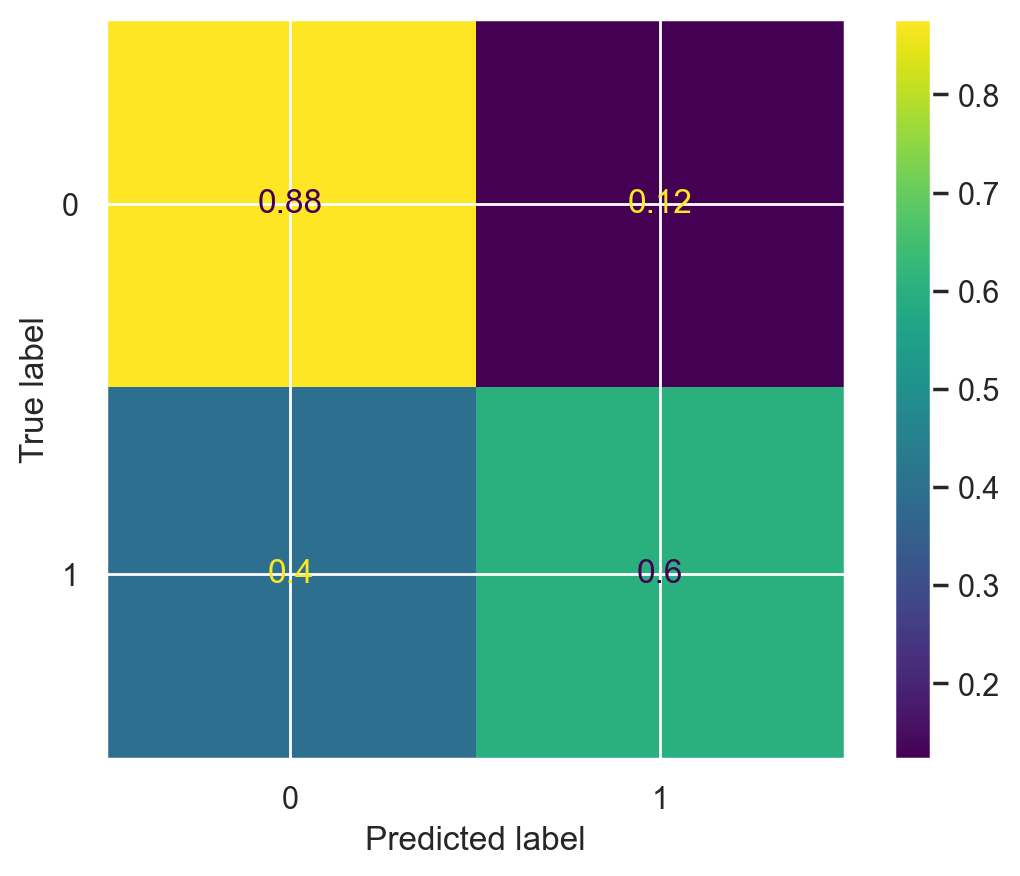

In [9]:
# Test Set
plot_confusion_table(y_test, test_predictions)

This classifier's skill is similar to previous one, and has still some level of overfitting.